# Rede Neural de Múltiplas Camadas para Regressão Simbólica

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, LassoLarsCV
import warnings
import os
import pickle

# ignoramos os resultados NaN das funções pois vamnos zera-los
np.seterr(invalid='ignore')
# nao quero warning de convergência
warnings.filterwarnings('ignore')

In [2]:
def getResults(fname='results.pkl'):
    dataset = []
    algoritmo = []
    ninter_l = []
    inter_min_l  = []
    inter_max_l  = []
    msre_l = []
    if os.path.exists(fname):
        fw = open(fname, 'rb')
        dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l  = pickle.load(fw)
        fw.close()
    return dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l

In [3]:
def storeResults(dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l, fname='results.pkl'):
    fw = open(fname, 'wb')
    pickle.dump((dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l), fw)
    fw.close()

- calcula mean square root error

In [4]:
def msre(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

- carrega os dados do arquivo fname e retorna X, y

In [5]:
def importaDados(fname):
    dataset = np.loadtxt(fname, delimiter=",")
    X = dataset[:, :-1]
    y = dataset[:, -1]
    return (X, y)

- recebe uma matriz X e uma rede de expoentes
- retorna os dados transformados
- substitui todos os valores NaN e Inf para 0

In [6]:
def transformData(X, rede):
    n_rows = X.shape[0]
    n_inter = rede.shape[1]
    layers = np.ndarray((n_rows, 3*n_inter))
    for i in range(0, n_inter*3, 3):
        power = X**rede[:,int(i/3)]
        layers[:,i] = np.prod(power,axis=1) # id
        layers[:,i+1] = np.cos(layers[:,i]) # cos
        layers[:,i+2] = np.sqrt(layers[:,i]) # sqrt
    cols = np.any(np.isnan(layers), axis=0)
    layers[:, cols] = 0
    cols = np.any(np.isinf(layers), axis=0)
    layers[:, cols] = 0
    return layers

- Cria a camada de expoentes da rede com n_inter neurônios
- Aplica a função transformData em X_train utilizando essa rede
- Divida a base entre treino e validação
- Aplique o LassoCV e LassoLarsCV, verifique na validação o que retorna o menor erro
- Retorne a rede e o modelo de menor erro
- expoentes aleatorios de 0 a 2

In [7]:
def fit(X, y, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    exponents = np.random.randint(inter_min, inter_max, size=(n_inputs, n_inter))
    X_transf = transformData(X, exponents)
    lasso = LassoCV(max_iter=5e4, cv=3)
    lassoLars = LassoLarsCV(max_iter=5e4, cv=3)
    lasso.fit(X_transf, y)
    lassoLars.fit(X_transf, y)
    return exponents, lasso, lassoLars

- Aplica transformData em X_test usando a rede
- Aplique o método predict de modelo na base transformada e armazena a saída em y_hat
- Retorna y_hat

In [8]:
def predict(X, rede, modelo):
    X_transf = transformData(X, rede)
    y_hat = modelo.predict(X_transf)
    return y_hat

- main

In [28]:
dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l = getResults('results.pkl')

In [ ]:
#ninter_list = [10, 50, 100, 500, 1000]
inter_min_max = [(-1,1), (-2,2), (-3,3), (-4,4), (-5,5), (0,1), (0,2), (0,3), (0,4), (0,5)]
pastas = ['0', '1', '2', '3', '4']
#bases = ['airfoil', 'concrete', 'cpu', 'energyCooling', 'energyHeating', 'forestfires', 'towerData', 'wineRed', 'wineWhite', 'yacht']
#basesquebugam = ['bioavailability', 'ppb']

#for D in bases:
D = 'concrete'
#for ninter in ninter_list:
ninter = 10
for (inter_min, inter_max) in inter_min_max:
    dataset += [D, D]
    ninter_l += [ninter, ninter]
    inter_min_l += [inter_min, inter_min]
    inter_max_l += [inter_max, inter_max]
    algoritmo += ['lasso', 'lassoLars']
    msre_lasso = 0
    msre_lassoLars = 0
    for pasta in pastas:
        fileTrain = 'datasets/' + D + '-train-' + pasta + '.dat'
        X, y = importaDados(fileTrain)
        n = X.shape[1]
        X_treino, X_validacao, y_treino, y_validacao = train_test_split(X, y, test_size=0.3, random_state=1)
        rede, lasso, lassoLars = fit(X_treino, y_treino, ninter*n, inter_min, inter_max)
        y_lasso = predict(X_validacao, rede, lasso)
        y_lars = predict(X_validacao, rede, lassoLars)
        msre_lasso += msre(y_validacao, y_lasso)
        msre_lassoLars += msre(y_validacao, y_lars)
    m = len(pastas)
    msre_l += [msre_lasso/m, msre_lassoLars/m]

In [ ]:
storeResults(dataset, algoritmo, ninter_l, inter_min_l, inter_max_l, msre_l, 'results.pkl')

In [29]:
dataframe = {'dataset':dataset, 
             'algoritmo':algoritmo, 
             'ninter': ninter_l, 
             'inter_min':inter_min_l, 
             'inter_max':inter_max_l, 
             'msre':msre_l}
df = pd.DataFrame(dataframe)

In [30]:
df

,algoritmo,dataset,inter_max,inter_min,msre,ninter
0,lasso,airfoil,1,-1,6.371157,10
1,lassoLars,airfoil,1,-1,5.098648,10
2,lasso,airfoil,2,-2,6.926748,10
3,lassoLars,airfoil,2,-2,3.765644,10
4,lasso,airfoil,3,-3,6.822921,10
5,lassoLars,airfoil,3,-3,3.893422,10
6,lasso,airfoil,4,-4,6.780489,10
7,lassoLars,airfoil,4,-4,3.628982,10
8,lasso,airfoil,5,-5,6.959822,10
9,lassoLars,airfoil,5,-5,4.575020,10


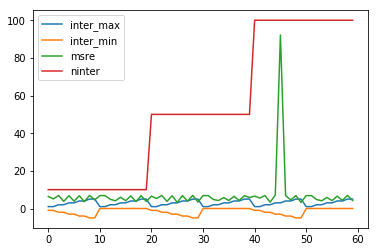

In [34]:
df.plot()